In [1]:
import pickle as pk

df = pk.load(open('/home/lscsc/caizhijie/0420-wamera-benchmark/validdumps_newrun-1-valid.pk', 'rb'))

In [2]:
namelist = list()
jhmlist = list()
y_jhmlist = list()

for i in range(1, len(df)):
    namelist.extend(df[i][1])
    jhmlist.extend(df[i][2])
    y_jhmlist.extend(df[i][3])

In [3]:
import numpy as np

namelist_ = list()
jhmlist_ = list()
y_jhmlist_ = list()

n_frame = 5

for i in range(0, len(namelist), n_frame):
    namelist_.append(namelist[i])
    jhmlist_.append(np.concatenate(jhmlist[i:i+n_frame]))
    y_jhmlist_.append(np.concatenate(np.stack(y_jhmlist[i:i+n_frame])))

In [5]:
import pandas as pd

df = pd.DataFrame.from_dict({'name':namelist_, 'jhm':jhmlist_, 'y_jhm':y_jhmlist_})

In [18]:
import torch

from torch.utils.data import Dataset, DataLoader

class dataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __getitem__(self, index):
        return self.df.iloc[index]
    
    def __len__(self):
        return len(self.df)
    
def collate_fn(batch):
    jhm = list()
    y_jhm = list()
    name = list()
    for b in batch:
        jhm.append(b['jhm'])
        y_jhm.append(b['y_jhm'])
        name.append(b['name'])
        
    return np.stack(jhm), np.stack(y_jhm), name

df_ = df.sample(frac=1.0)
dl = DataLoader(dataset(df_.iloc[:int(len(df_) * 0.8)]), batch_size=8, collate_fn=collate_fn, shuffle=True)
# dl = DataLoader(dataset(df), batch_size=8, collate_fn=collate_fn, shuffle=True)

dl_ = DataLoader(dataset(df_.iloc[int(len(df_) * 0.8):]), batch_size=8, collate_fn=collate_fn, shuffle=True)

In [50]:
import torch.nn.functional as F
import torch.nn as nn

device = 'cuda:0'

class FocalLoss(nn.Module):
    def __init__(self, alpha=[0.33, 0.67], gamma=2, reduction='mean'):
        """
        :param alpha: 权重系数列表，三分类中第0类权重0.2，第1类权重0.3，第2类权重0.5
        :param gamma: 困难样本挖掘的gamma
        :param reduction:
        """
        super(FocalLoss, self).__init__()
        self.alpha = torch.tensor(alpha).to(device)
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, pred, target):
        alpha = self.alpha[target]  # 为当前batch内的样本，逐个分配类别权重，shape=(bs), 一维向量
        log_softmax = torch.log_softmax(pred, dim=1) # 对模型裸输出做softmax再取log, shape=(bs, 3)
        logpt = torch.gather(log_softmax, dim=1, index=target.view(-1, 1))  # 取出每个样本在类别标签位置的log_softmax值, shape=(bs, 1)
        logpt = logpt.view(-1)  # 降维，shape=(bs)
        ce_loss = -logpt  # 对log_softmax再取负，就是交叉熵了
        pt = torch.exp(logpt)  #对log_softmax取exp，把log消了，就是每个样本在类别标签位置的softmax值了，shape=(bs)
        focal_loss = alpha * (1 - pt) ** self.gamma * ce_loss  # 根据公式计算focal loss，得到每个样本的loss值，shape=(bs)
        if self.reduction == "mean":
            return torch.mean(focal_loss)
        if self.reduction == "sum":
            return torch.sum(focal_loss)
        return focal_loss

In [53]:
import tqdm


class simpleNN(nn.Module):
    def __init__(self, in_channels=380):
        super().__init__()
        
        self.process = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * 2, 3, 2, 1, 1),
            nn.BatchNorm2d(in_channels * 2),
            nn.ReLU(),
            nn.Conv2d(in_channels * 2, in_channels * 2 * 3, 3, 3, 1, 1),
            nn.BatchNorm2d(in_channels * 2 * 3),
            nn.ReLU(),
            nn.Conv2d(in_channels * 2 * 3, in_channels * 2 * 3, 3, 3, 1, 1),
            nn.BatchNorm2d(in_channels * 2 * 3),
            nn.ReLU(),
            nn.Conv2d(in_channels * 2 * 3, in_channels * 2 * 3, 3, 3, 1, 1),
            nn.BatchNorm2d(in_channels * 2 * 3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(760 * 6, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 2),
            nn.ReLU(),
            nn.Softmax(),
        )
        
    def forward(self, x):
        return self.process(x)

device = 'cuda:0'
model = simpleNN().to(device)
model.train()


optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-5,
    weight_decay=1e-5,
)

bestacc = 0
bestepoch = 0
bestpd = list()
bestgt = list()

floss = FocalLoss()

for j in range(50):
    n_all = 0
    n_hit = 0
    pbar = tqdm.tqdm(enumerate(dl), total=len(dl))
    model.train()
    for i, batch in pbar:
        jhm, y_jhm, name = batch
        x = torch.tensor(jhm).to(device)
        y = torch.tensor([_.__contains__('group0') for _ in name]).long().to(device)
        pred = model(x)
        
        loss = F.cross_entropy(pred, y)
        # loss = floss(pred, y)
        
        n_hit += (y == pred.argmax(1)).sum()
        n_all += len(y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pbar.set_description('%s, batch: %d/%d, loss: %.4f, acc: %.2f' % ('train', i, len(pbar), loss, n_hit / n_all))
    
    n_all = 0
    n_hit = 0
    pd = list()
    gt = list()
    pbar_ = tqdm.tqdm(enumerate(dl_), total=len(dl_))
    with torch.no_grad():
        for i, batch in pbar_:
            jhm, y_jhm, name = batch
            x = torch.tensor(jhm).to(device)
            y = torch.tensor([_.__contains__('group0') for _ in name]).long().to(device)
            pred = model(x)
            
            loss = F.cross_entropy(pred, y)
            # loss = floss(pred, y)
            
            n_hit += (y == pred.argmax(1)).sum()
            n_all += len(y)
            
            pd.extend(list(pred.argmax(1).detach().cpu().numpy()))
            gt.extend(list(y.detach().cpu().numpy()))

            pbar_.set_description('%s, batch: %d/%d, loss: %.4f, acc: %.2f' % ('valid', i, len(pbar), loss, n_hit / n_all))
    
    previousacc = n_hit / n_all
    if previousacc > bestacc:
        bestacc = previousacc
        bestpd = pd
        bestgt = gt
        bestepoch = j
        print('updated best: epoch %d' % j)

valid, batch: 14/60, loss: 0.6557, acc: 0.68: 100%|██████████| 15/15 [00:02<00:00,  5.45it/s]


updated best: epoch 0


valid, batch: 14/60, loss: 0.6695, acc: 0.71: 100%|██████████| 15/15 [00:02<00:00,  5.61it/s]


updated best: epoch 1


valid, batch: 14/60, loss: 0.6142, acc: 0.76: 100%|██████████| 15/15 [00:02<00:00,  5.47it/s]


updated best: epoch 2


valid, batch: 14/60, loss: 0.4469, acc: 0.77: 100%|██████████| 15/15 [00:02<00:00,  5.66it/s]


updated best: epoch 10


valid, batch: 14/60, loss: 0.5628, acc: 0.78: 100%|██████████| 15/15 [00:02<00:00,  5.41it/s]


updated best: epoch 13


valid, batch: 14/60, loss: 0.4498, acc: 0.81: 100%|██████████| 15/15 [00:02<00:00,  5.41it/s]


updated best: epoch 15


valid, batch: 14/60, loss: 0.4389, acc: 0.82: 100%|██████████| 15/15 [00:02<00:00,  5.66it/s]


updated best: epoch 21


valid, batch: 14/60, loss: 0.3338, acc: 0.86: 100%|██████████| 15/15 [00:02<00:00,  5.47it/s]


updated best: epoch 29


valid, batch: 14/60, loss: 0.3168, acc: 0.80: 100%|██████████| 15/15 [00:02<00:00,  5.52it/s]


In [54]:

#true positive
TP = np.sum(np.logical_and(np.equal(gt,1),np.equal(pd,1)))
print(TP)
 
#false positive
FP = np.sum(np.logical_and(np.equal(gt,0),np.equal(pd,1)))
print(FP)
 
#true negative
TN = np.sum(np.logical_and(np.equal(gt,1),np.equal(pd,0)))
print(TN)
 
#false negative
FN = np.sum(np.logical_and(np.equal(gt,0),np.equal(pd,0)))
print(FN)

24
11
13
72


[Text(0, 0.5, 'event: fall'), Text(0, 1.5, 'event: non-fall')]

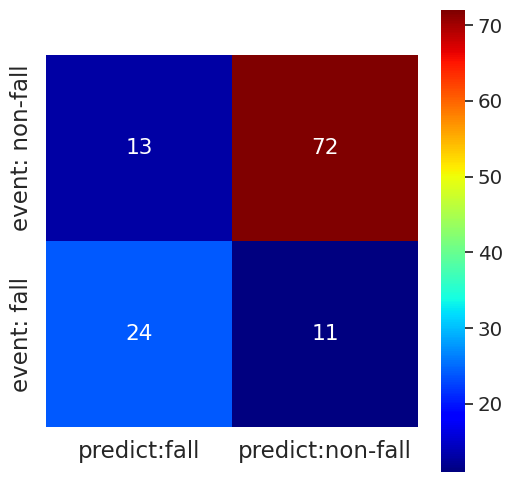

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

sns.set(font_scale=1.3)
g = sns.heatmap(data=np.array([[TP, FP], [TN, FN]]), cmap='jet', square=True, annot=True)
ax.invert_yaxis()
g.set_xticklabels(['predict:fall', 'predict:non-fall'])
g.set_yticklabels(['event: fall', 'event: non-fall'])

In [55]:
precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + FP + TN + FN)
error_rate =  (FN + FP) / (TP + FP + TN + FN)

precision, recall, accuracy, error_rate

(0.6857142857142857, 0.25, 0.30833333333333335, 0.6916666666666667)

In [88]:
2 * precision * recall / (precision + recall)

0.366412213740458